<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/CH.1/Logistic_Regression(%2Bscaler).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Logistic Regression

- Data set : sklearn이 제공하는 IRIS

  -> 꽃의 종류와 꽃의 특징 4가지로 이루어져 있음

- Scaler 종류 바꿔가며 비교해보기

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torch.nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

[1] Data Processing

In [3]:
data = datasets.load_iris()

data
# dictionary 형태로 저장되어 있으므로 CSV 형태로 바꿔줘야 함

{'DESCR': '.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ===========

In [7]:
input_data = data['data']
target_data = data['target']

name = data['target_names']
feature = data['feature_names']

# Dataframe 사용하여 정리
iris_df = pd.DataFrame(input_data, columns=feature)
iris_df['species'] = target_data

print(iris_df.shape)
iris_df

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [8]:
# train, test data 나누기

x_train, x_test, y_train, y_test = train_test_split(input_data, target_data, test_size = 0.2, random_state = 1234 )
print("x_train의 크기:{}",x_train.shape)
print("y_train의 크기:{}",y_train.shape)
print("x_testn의 크기:{}",x_test.shape)
print("y_test의 크기:{}",y_test.shape)


x_train의 크기:{} (120, 4)
y_train의 크기:{} (120,)
x_testn의 크기:{} (30, 4)
y_test의 크기:{} (30,)


In [34]:
#학습 데이터 Scaling
#scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler = RobustScaler()
scaler.fit(x_train)
x_train_tran = scaler.transform(x_train)


#학습 데이터 배치화 시키기 
train_data = data_utils.TensorDataset(torch.FloatTensor(x_train_tran),
                                 torch.FloatTensor(y_train))

dataloader = data_utils.DataLoader(train_data, batch_size=40, shuffle=False)


#배치화된 데이터 확인
for batch_idx, datas in enumerate(dataloader):
    print(batch_idx)
    print(datas[0].shape)
    print(datas[1].shape)
    break

    
#테스트 데이터 Scaling    
x_test_tran = scaler.transform(x_test)


#테스트 데이터 텐서로 변환
x_test_tensor = torch.FloatTensor(x_test_tran)
y_test_tensor = torch.FloatTensor(y_test)

0
torch.Size([40, 4])
torch.Size([40])


[2] Model

In [35]:
class LogisticRegression(torch.nn.Module):
        def __init__(self, input_size, output_size):
            super(LogisticRegression, self).__init__()
            self.input_size = input_size
            self.output_size = output_size
            self.linear = torch.nn.Linear(self.input_size, self.output_size)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, input_tensor):
            linear1 = self.linear(input_tensor)
            output = self.sigmoid(linear1)
            return output

#Hyper-parameter
input_size = 4
output_size = 1
learning_rate = 0.1
n_epochs = 200

#model 생성
model = LogisticRegression(input_size=input_size, output_size=output_size)

#손실함수 생성
criterion = torch.nn.MSELoss() 
#Optimizer 생성
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

[3] Training

In [36]:
train_loss = []
test_loss = []

for epoch in range(n_epochs+1):
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_batch)
        y_pred = y_pred.reshape(-1)

        loss_train = criterion(y_pred.squeeze(), y_batch)

        loss_train.backward()
        optimizer.step()

        #Validation
        model.eval()
        y_test_pred = model(x_test_tensor)
        
        y_test_pred = y_test_pred.reshape(-1)
        
        loss_test = criterion(y_test_pred, y_test_tensor)
    train_loss.append(loss_train.item())
    test_loss.append(loss_test.item())
    print("epoch:{}, Loss_train:{:.2f}, Loss_test:{:.2f}".format( epoch, train_loss[-1], test_loss[-1]))

epoch:0, Loss_train:1.05, Loss_test:0.78
epoch:1, Loss_train:1.00, Loss_test:0.73
epoch:2, Loss_train:0.94, Loss_test:0.69
epoch:3, Loss_train:0.89, Loss_test:0.65
epoch:4, Loss_train:0.85, Loss_test:0.61
epoch:5, Loss_train:0.81, Loss_test:0.58
epoch:6, Loss_train:0.78, Loss_test:0.55
epoch:7, Loss_train:0.75, Loss_test:0.53
epoch:8, Loss_train:0.72, Loss_test:0.51
epoch:9, Loss_train:0.70, Loss_test:0.49
epoch:10, Loss_train:0.68, Loss_test:0.47
epoch:11, Loss_train:0.66, Loss_test:0.46
epoch:12, Loss_train:0.64, Loss_test:0.45
epoch:13, Loss_train:0.63, Loss_test:0.43
epoch:14, Loss_train:0.62, Loss_test:0.42
epoch:15, Loss_train:0.60, Loss_test:0.42
epoch:16, Loss_train:0.59, Loss_test:0.41
epoch:17, Loss_train:0.58, Loss_test:0.40
epoch:18, Loss_train:0.58, Loss_test:0.39
epoch:19, Loss_train:0.57, Loss_test:0.39
epoch:20, Loss_train:0.56, Loss_test:0.38
epoch:21, Loss_train:0.55, Loss_test:0.38
epoch:22, Loss_train:0.55, Loss_test:0.37
epoch:23, Loss_train:0.54, Loss_test:0.37
ep

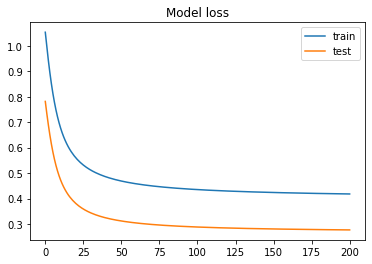

In [37]:
# Loss 값 plot

plt.figure()
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Model loss')
plt.legend(loc= 'upper right')
plt.show()
